In [1]:
import h3
import h3pandas
import numpy as np
import pandas as pd
import pydeck as pdk
import seaborn as sns
import networkx as nx
from cflp_function import *
from shapely.geometry import Polygon
from calculate_od import *
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation

c:\Users\User\anaconda3\envs\scip\lib\site-packages\spaghetti\network.py:40: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [2]:
# import os
# os.environ['USE_PYGEOS'] = '0'
# import geopandas as gpd

In [3]:
hex = pd.read_csv('./hex/hex_df2.csv')
# get_fill_color(hex, "fuzzy", "viridis")

In [4]:
# Define a layer to display on a map
# layer = pdk.Layer(
#     "H3HexagonLayer",
#     hex,
#     pickable=True,
#     # stroked=True,
#     filled=True,
#     extruded=False,
#     auto_highlight=True,
#     opacity=0.6,
#     get_hexagon="hex9",
#     get_fill_color = 'color', 
#     get_line_color=[255, 255, 255],
#     line_width_min_pixels=0.1
#     )

# # Set the viewport location
# view_state = pdk.ViewState(longitude=6.747489560596507, latitude=52.316862707395394, zoom=9, bearing=0, pitch=0)

# # Render
# r = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip={"text": "Value: {fuzzy}"})
# r.to_html("layer.html")

### H3 indices and polygon geometries
We want to have a geodataframe that stores the H3 indices in study area and the polygon geometries

In [5]:
lst = gpd.read_file('./h3_list.shp')

In [6]:
idx = pd.DataFrame(index=lst.hex9)

In [7]:
idx = idx.h3.h3_to_geo_boundary()

In [8]:
idx = gpd.GeoDataFrame(idx, geometry='geometry', crs='EPSG:4326')

In [9]:
# def cell_to_shapely_polygon(h3_index):
#     """
#     A function to convert H3 index to Shapely polygons

#     """
#     # hex_center_coords = h3.h3_to_geo(h3_index)
#     coords = h3.h3_to_geo_boundary(h3_index)
#     flipped = tuple(coord[::-1] for coord in coords)
#     # center_point = Point(hex_center_coords)
#     return Polygon(flipped) #, center_point

In [10]:
# hex['geometry'] = hex['hex9'].apply(cell_to_shapely_polygon) # can change the function here
# gdf = gpd.GeoDataFrame(hex, geometry='geometry', crs=4326)

### Merge compound suitability map and H3 geometry information

In [11]:
# gdf = idx.merge(hex[['hex9','color','fuzzy']], on='hex9',how='left')

### Spatial Autocorrelation

In [12]:
w_queen = weights.Queen.from_dataframe(idx, use_index=True)

c:\Users\User\anaconda3\envs\scip\lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 2 islands with ids: 891f16c693bffff, 891f1610e8fffff.
  warnings.warn(message)


In [13]:
w_queen.min_neighbors

0

In [14]:
w_queen.max_neighbors

6

In [15]:
w_queen.islands

['891f16c693bffff', '891f1610e8fffff']

In [16]:
# # view islands - those that don't have any neighbors
# ax=idx.plot(color='k', figsize=(6,6))
# idx.loc[w_queen.islands,:].plot(color='red', ax=ax)

In [17]:
# Drop the islands
idx = idx.drop(w_queen.islands)

In [18]:
# recalculate spatial weights matrix
w = weights.Queen.from_dataframe(idx, use_index=True)

c:\Users\User\anaconda3\envs\scip\lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
  warnings.warn(message)


In [19]:
# Row standardize the matrix
w.transform = 'R'

In [20]:
# Reindex the compound suitability df such that its indices are ordered as the H3 list geodataframe
# hex_df = hex.set_index('hex9').reindex(idx.index)
hex_df = idx.merge(hex[['hex9','color','fuzzy']], on='hex9',how='left')

In [21]:
# Get standardised fuzzy values
hex_df['fuzzy_std'] = (hex_df['fuzzy'] - hex_df['fuzzy'].mean()) / hex_df['fuzzy'].std()

In [22]:
hex_df['lag_std'] = weights.lag_spatial(w, hex_df['fuzzy_std'])

In [23]:
hex_df['lag'] = weights.lag_spatial(w, hex_df['fuzzy'])

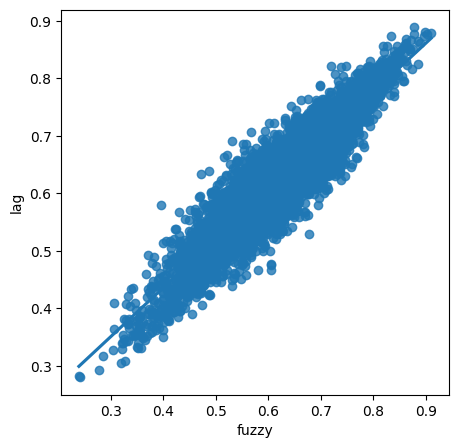

In [24]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(5, 5))
# Plot values
sns.regplot(x='fuzzy', y='lag', data=hex_df, ci=None)
# Add vertical and horizontal lines
# plt.axvline(0, c='k', alpha=0.5)
# plt.axhline(0, c='k', alpha=0.5)
# # plt.text(1.75, 0.5, "HH", fontsize=25)
# # plt.text(1.5, -1.5, "HL", fontsize=25)
# # plt.text(-2, 1, "LH", fontsize=25)
# # plt.text(-1.5, -2.5, "LL", fontsize=25)
# Display
plt.show()

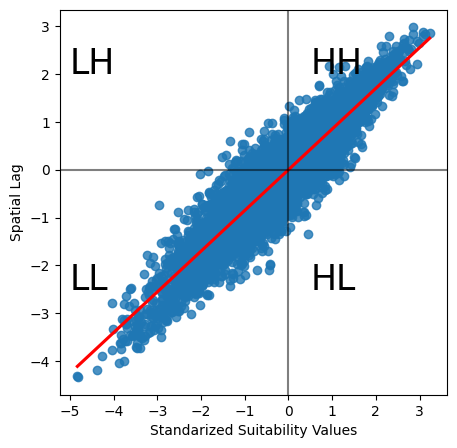

In [25]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(5, 5))
# Plot values
sns.regplot(x='fuzzy_std', y='lag_std', data=hex_df, ci=None, line_kws=dict(color="r"))
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
ax.set_xlabel('Standarized Suitability Values')
plt.axhline(0, c='k', alpha=0.5)
ax.set_ylabel('Spatial Lag')
plt.text(0.5, 2, "HH", fontsize=25)
plt.text(0.5, -2.5, "HL", fontsize=25)
plt.text(-5, 2, "LH", fontsize=25)
plt.text(-5, -2.5, "LL", fontsize=25)
# Display
plt.show()

In [26]:
lisa = esda.Moran_Local(hex_df['fuzzy'], w)
# Break observations into significant or not
hex_df['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
hex_df['quadrant'] = lisa.q

In [27]:
# lisa_cluster(lisa, hex_df)

In [28]:
# plot_local_autocorrelation(lisa, hex_df, 'fuzzy')

In [29]:
# ax = hex_df.plot(color='k', figsize=(9, 9))
# hex_df[(hex_df['significant'] == True) & (hex_df['quadrant'] == 1)].plot(color='red', ax=ax)
# ax.set_axis_off()

### HH Clusters to Connected Graphs

In [30]:
w

In [31]:
# pd.DataFrame(*w.full()).astype(int)

In [32]:
# Transform weight back to Binary
w.transform = 'B'

In [33]:
len(hex)

11628

In [34]:
g = w.to_networkx()

In [35]:
print("Number of nodes:", nx.number_of_nodes(g))
print("Number of edges:", nx.number_of_edges(g))
# print("Nodes:", g.nodes())
# print("Edges:", g.edges())

Number of nodes: 11626
Number of edges: 31726


In [36]:
# NetworkX relabeled the nodes with integer starting from 0, we want the nodes to be labeled by their H3 index 
mapping = {new_index: old_index for new_index, old_index in enumerate(w.id_order)}

In [37]:
# Apply the mapping to the graph
g = nx.relabel_nodes(g, mapping)

In [38]:
print("Nodes:", g.nodes())

Nodes: ['891f1655aa3ffff', '891f1655aa7ffff', '891f1655bd3ffff', '891f1655bd7ffff', '891f1655b8bffff', '891f1655ab7ffff', '891f1655a87ffff', '891f1655ab3ffff', '891f1655a93ffff', '891f1655a97ffff', '891f165584bffff', '891f165584fffff', '891f165586bffff', '891f165586fffff', '891f1655b9bffff', '891f165587bffff', '891f1655863ffff', '891f1655867ffff', '891f1655b93ffff', '891f1655847ffff', '891f1655873ffff', '891f1655877ffff', '891f1655e87ffff', '891f1655eb3ffff', '891f1655eb7ffff', '891f165582bffff', '891f165580bffff', '891f165580fffff', '891f165583bffff', '891f1655823ffff', '891f165581bffff', '891f1655803ffff', '891f1655807ffff', '891f1655833ffff', '891f1655837ffff', '891f1655857ffff', '891f1655c6bffff', '891f1655c6fffff', '891f165589bffff', '891f1655c7bffff', '891f1655c63ffff', '891f1655c67ffff', '891f1655893ffff', '891f1655c73ffff', '891f1655c77ffff', '891f1655167ffff', '891f1655e93ffff', '891f1655177ffff', '891f165512bffff', '891f165513bffff', '891f1655123ffff', '891f1655133ffff', '891

In [39]:
# Get indices of H3 cells that are in the HH quadrant
HH = hex_df[(hex_df['significant'] == True) & (hex_df['quadrant'] == 1)].hex9.to_list()

In [40]:
# Get sub graph that includes only the HH quadrant
H = g.subgraph(HH)

In [41]:
print("Number of nodes:", nx.number_of_nodes(H))
print("Number of edges:", nx.number_of_edges(H))

Number of nodes: 2543
Number of edges: 5929


In [42]:
nx.write_graphml(g, './g.graphml')

In [43]:
nx.write_graphml(H, './H.graphml')

In [44]:
sub = list(nx.connected_components(H))

In [45]:
len(sub)

68

In [47]:
hex_df.to_file('./h3.shp')

C:\Users\User\AppData\Local\Temp\ipykernel_18324\364883459.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  hex_df.to_file('./h3.shp')


In [48]:
sub_size = [len(c) for c in sorted(nx.connected_components(H), key=len, reverse=True)]

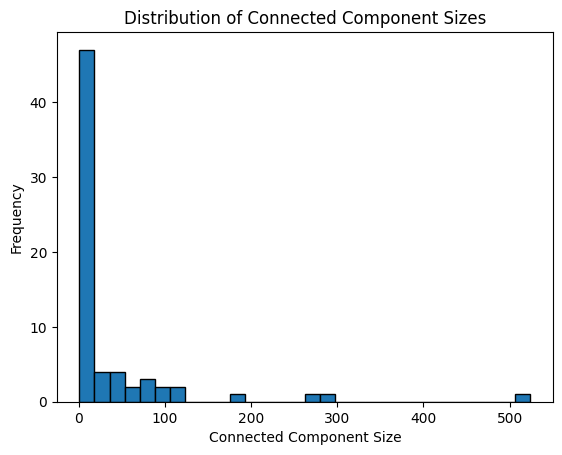

In [52]:
# Plotting the histogram
plt.hist(sub_size, bins=30, edgecolor='black')
plt.xlabel('Connected Component Size')
plt.ylabel('Frequency')
plt.title('Distribution of Connected Component Sizes')
plt.show()

In [56]:
len(set(sub_size))

35

In [59]:
from collections import Counter
# Use Counter to count occurrences of each value
value_counts = Counter(sub_size)

# Get the 10 most common values
most_common_values = value_counts.most_common(10)

# Display the result
print("10 most common values and their counts:")
for value, count in most_common_values:
    print(f"{value}: {count}")

10 most common values and their counts:
1: 25
40: 2
16: 2
15: 2
14: 2
10: 2
5: 2
4: 2
3: 2
2: 2


In [103]:
# queen_card = pd.Series(w_queen.cardinalities)

In [104]:
# plt.hist(queen_card, bins=10)

In [105]:
# w_rook = weights.Rook.from_dataframe(gdf, use_index=True)

In [106]:
# rook_card = pd.Series(w_rook.cardinalities)

In [107]:
# plt.hist(rook_card, bins=10)

In [108]:
# Row-standardize the queen matrix, 'R' = row, with all the neighbors of a given observation adding up to one.
# w_queen.transform = 'R'

In [109]:
# Compute spatial lag 
# lag = weights.lag_spatial(w_queen, gdf['value'])

In [110]:
# gdf['spatial_lag'] = lag

In [111]:
# fig, ax = plt.subplots(1, figsize=(9,9))
# sns.regplot(x='value', y='spatial_lag', data=gdf, ci=None)
# plt.show()

In [112]:
# Standardize spatial weights 
# std_v = (gdf['value'] - gdf['value'].mean()) / gdf['value'].std()

In [113]:
# std_w = pd.Series(weights.lag_spatial(w_queen, std_v), index=std_v.index)

In [114]:
# # Setup the figure and axis
# f, ax = plt.subplots(1, figsize=(9, 9))
# # Plot values
# sns.regplot(x=std_v, y=std_w, ci=None)
# # Add vertical and horizontal lines
# plt.axvline(0, c='k', alpha=0.5)
# plt.axhline(0, c='k', alpha=0.5)
# # Display
# plt.show()